In [2]:
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import scale
    import matplotlib.pyplot as plt
    import utils as ut
    import m_models as mm
    import os
    from tqdm import tqdm_notebook as tqdm

    import pylab

    import statsmodels.api as sm

    import scipy.stats as sps
    from scipy.optimize import minimize_scalar as minimize_scalar

    import pickle

    %load_ext autoreload
    %autoreload 2

In [3]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 40
plt.rcParams['axes.titlesize']= 36
plt.rcParams['axes.labelsize']= 40
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

---
Фиксируем константы

In [7]:
n = 4
M = 1000
sigma = 1

bootstrap_num_iter = 1000

---
Генерируем выборку

In [8]:
w = sps.uniform().rvs(n)

X = sps.norm(loc=0, scale=1).rvs(size=(M, n))
y = X @ w + sps.norm(loc=0, scale=sigma).rvs(size=M)

---
Ну или так

In [11]:
name = 'diabetes'

X, y = ut.DataLoader(name=name)
X, y = ut.preprocess(X, y)

n = y.shape[0]
M = X.shape[0]

bootstrap_num_iter = 100

In [9]:
statmodel = ut.define_model(y)

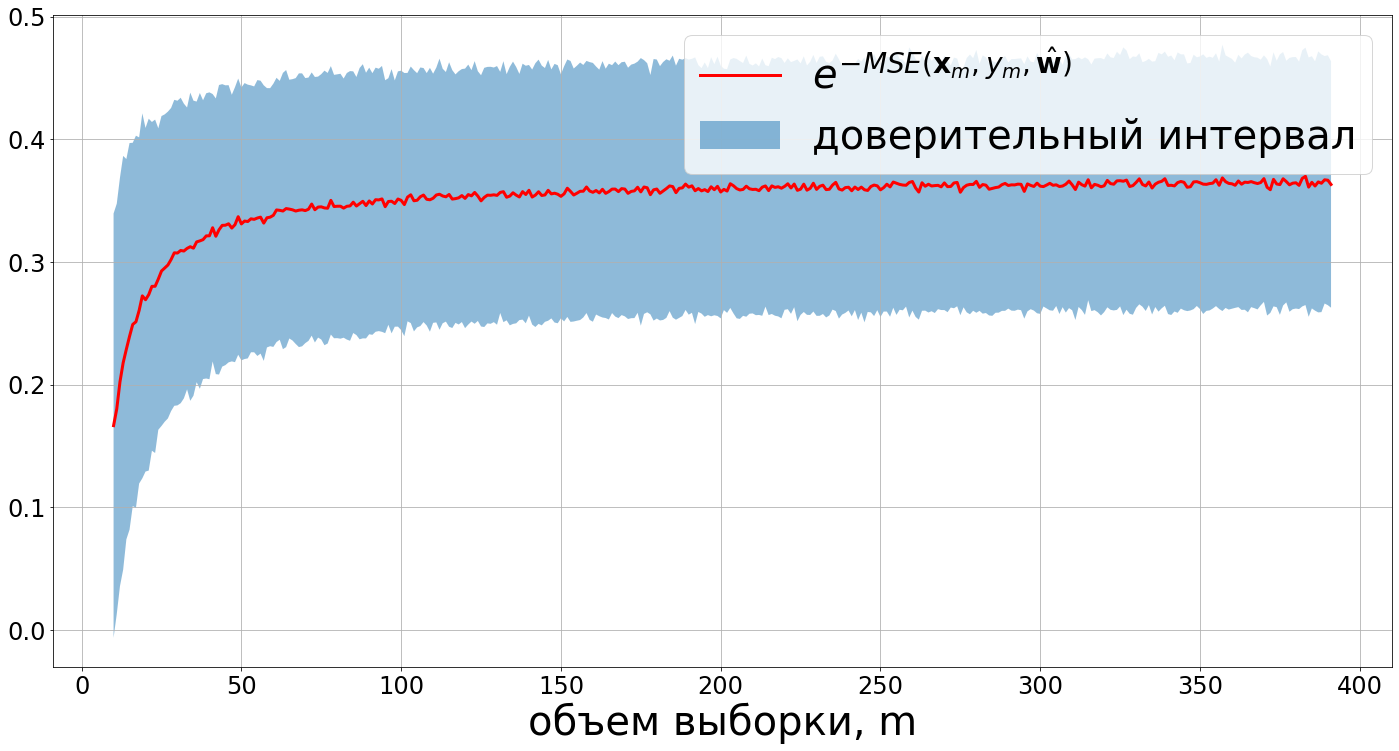

In [10]:
S = []
std = []

test_size = 50

for m_0 in tqdm(range(10, M - test_size)):
    
    mse = []
    
    for i in range(bootstrap_num_iter):
        
        idx = np.random.choice(M, size=m_0 + test_size, replace=False)
        
        X_cur = X[idx]
        y_cur = y[idx]
        
        X_train = X_cur[:-test_size]
        y_train = y_cur[:-test_size]
        X_test = X_cur[-test_size:]
        y_test = y_cur[-test_size:]
        
        w_hat = ut.get_params(X_train, y_train)
#         mse.append(np.mean((X_test @ w_hat - y_test) ** 2))
        mse.append(np.exp(-np.mean((X_test @ w_hat - y_test) ** 2)))
        
    S.append(np.mean(mse))
    std.append(np.std(mse))
    
S = np.asarray(S)
std = np.asarray(std)
    
plt.plot(np.arange(10, M - test_size), S, color='red', label='$e^{-MSE(\mathbf{x}_m, y_m, \hat{\mathbf{w}})}$')
plt.fill_between(np.arange(10, M - test_size), sps.norm(loc=S, scale=std).ppf(0.05), sps.norm(loc=S, scale=std).ppf(0.95),
                 alpha=0.5, label='доверительный интервал')

plt.xlabel('объем выборки, m')
plt.legend()
plt.grid()
# plt.savefig('../data/pics/synthetic_S.pdf', format='pdf')
plt.show()

---
Посчитаем ковариационную матрицу вектора параметров

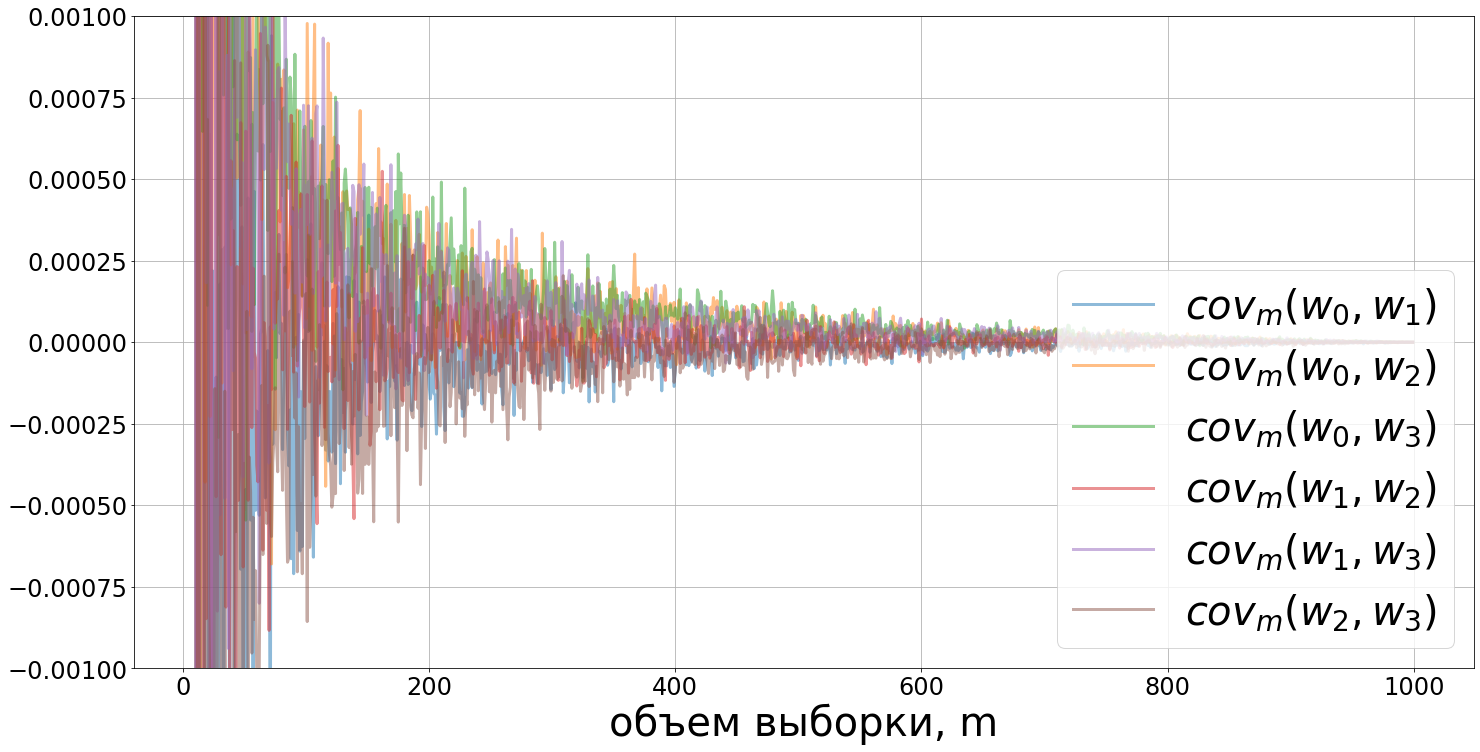

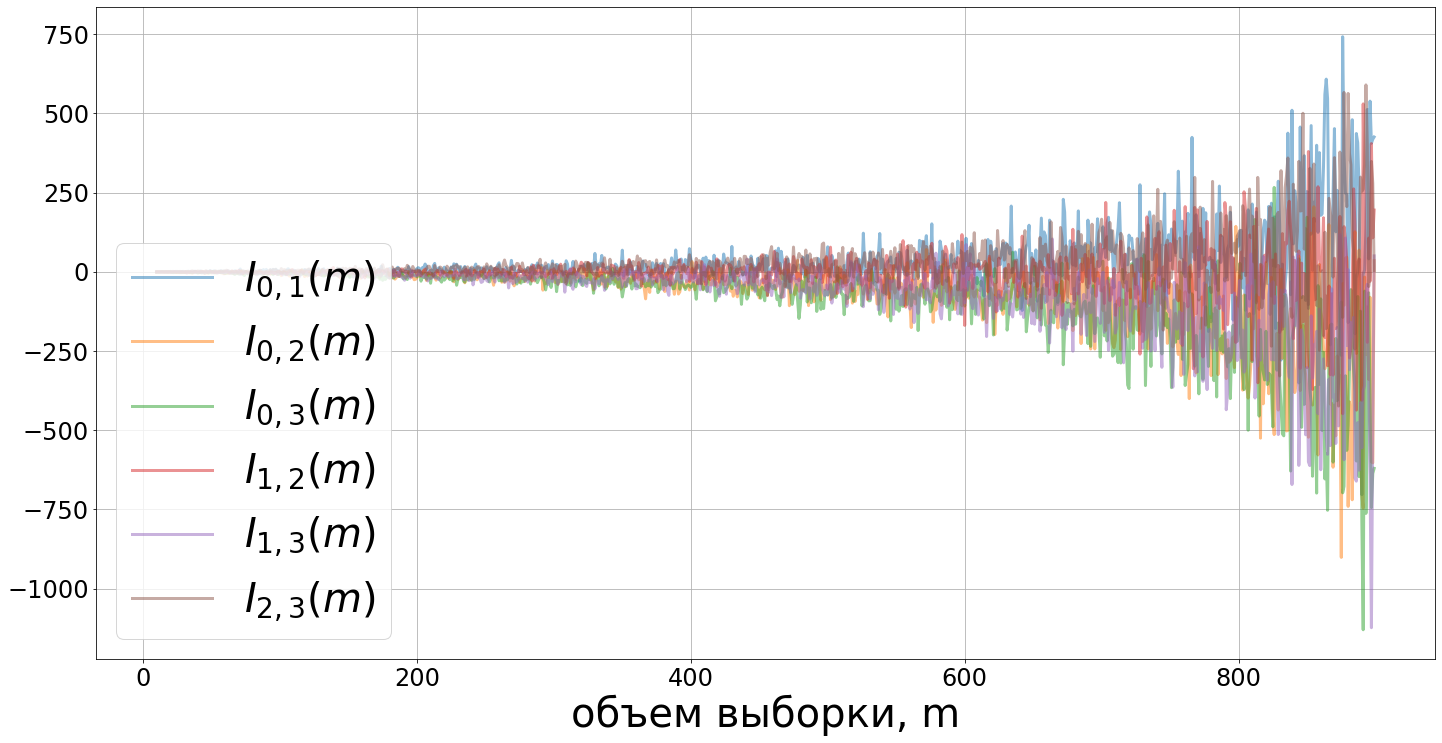

In [12]:
cov = []
I = []

for m in tqdm(range(10, M)):
    
    ans = []
    W = []
    W_mean = []
    
    for i in range(bootstrap_num_iter):
        idx = np.random.choice(M, size=m, replace=False)
        
        X_m = X[idx]
        y_m = y[idx]
        
        w_hat = ut.get_params(X_m, y_m)
        w_hat.resize((1, n))
        
        model = statmodel(y_m, X_m)
        ans.append((-model.hessian_fixed(w_hat)))
        W.append(w_hat)
    
    W = np.asarray(W)
    W -= W.mean(axis=0)
    ans = np.asarray(ans)
    
    cur_cov = np.zeros((n, n))
    
    for i in range(bootstrap_num_iter):
        cur_cov += W[i].T @ W[i]
    cov.append(cur_cov / (bootstrap_num_iter - 1))
    I.append(np.linalg.inv(cur_cov / (bootstrap_num_iter - 1)))

cov = np.asarray(cov)
I = np.asarray(I)

for i in range(cov.shape[0]):
    for j in range(i + 1, cov.shape[1]):
        plt.plot(np.arange(10, M), cov[:, i, j], alpha=0.5, label='$cov_m(w_{}, w_{})$'.format(i, j))
        

plt.xlabel('объем выборки, m')
plt.legend(loc='lower right')
plt.grid()
plt.ylim((-0.001, 0.001))
# plt.savefig('../data/pics/synthetic_W.pdf', format='pdf')
plt.show()

for i in range(cov.shape[0]):
    for j in range(i + 1, cov.shape[1]):
        plt.plot(np.arange(10, M - 100), I[:-100, i, j], alpha=0.5, label='$I_{%d, %d}(m)$' % (i, j))
        

plt.xlabel('объем выборки, m')
plt.legend(loc='lower left')
plt.grid()
# plt.savefig('../data/pics/synthetic_I.pdf', format='pdf')
plt.show()

# I_inv = np.asarray([np.linalg.inv(I[i]) for i in range(I.shape[0])])

# for i in range(cov.shape[0]):
#     for j in range(i + 1, cov.shape[1]):
#         plt.plot(np.arange(10, M), I_inv[:, i, j], alpha=0.5, label='$I^{-1}_{%d, %d}(m)$' % (i, j))
        

# plt.xlabel('объем выборки, m')
# plt.legend()
# plt.grid()
# #plt.savefig('../data/pics/synthetic_I.pdf', format='pdf')
# plt.show()

---
Теоретический (нечестный способ) нахождения $l(m)$.

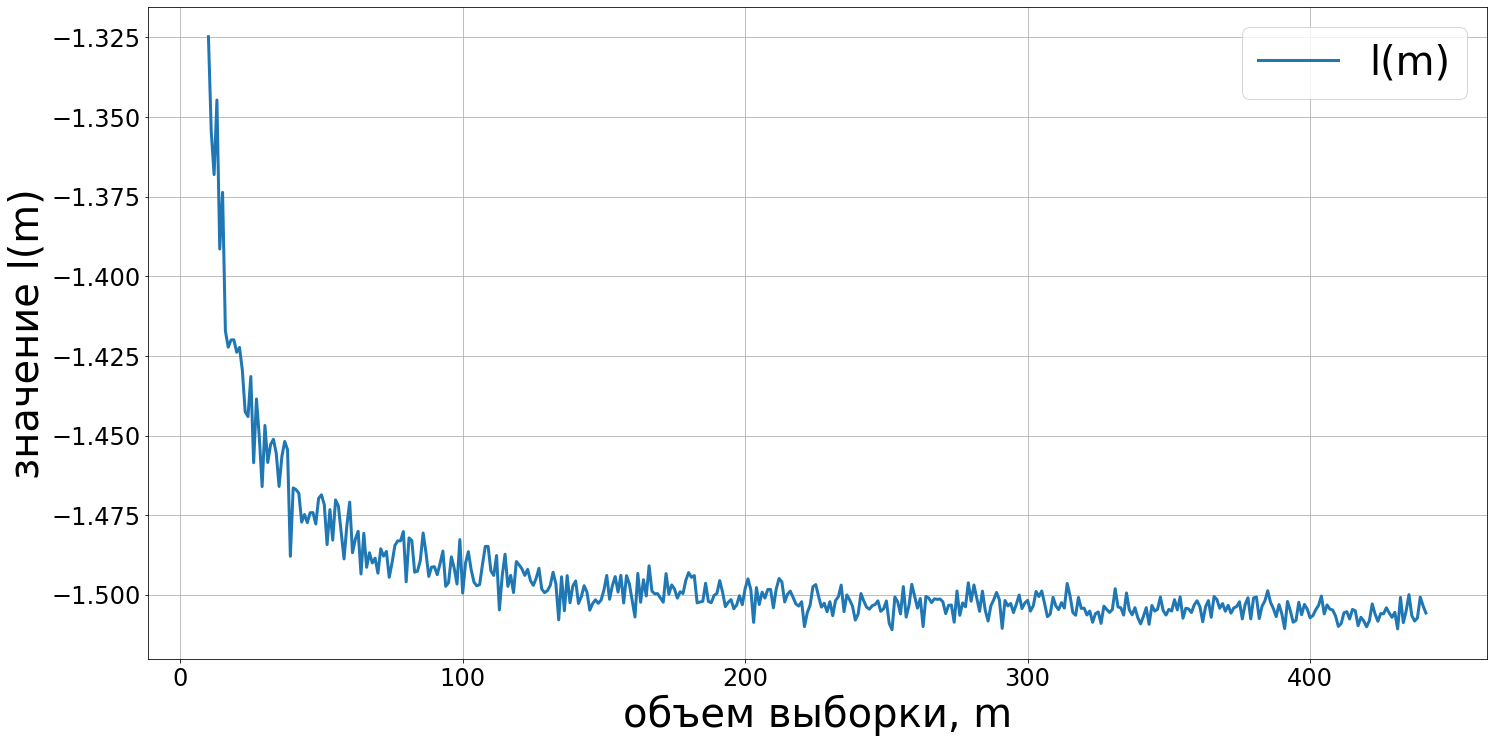

In [30]:
l = []

for m in tqdm(range(10, M)):
    
    l_m = []
    
    for i in range(bootstrap_num_iter):
        idx = np.random.choice(M, size=m)
        
        X_m = X[idx]
        y_m = y[idx]
        w_hat = ut.get_params(X_m, y_m)
        cur_loc = X_m @ w_hat
        cur_std = np.std(y_m)
        l_m.append(np.mean(sps.norm(loc=cur_loc, scale=cur_std).logpdf(y_m)))
    
    l.append(np.mean(l_m))
    
plt.plot(np.arange(10, M), l, label='l(m)')

plt.xlabel('объем выборки, m')
plt.ylabel('значение l(m)')
plt.legend()
plt.grid()
plt.savefig('../data/pics/diabetes_l.pdf', format='pdf')
plt.show()

---
Найдем набор оптимальных параметров $(a, b, c)$, что $MAE(a + bm^c, l(m)) \rightarrow min$.

In [13]:
m_0 = 100

In [32]:
def f(x):
    a = x[0]
    b = x[1]
    c = x[2]
    return np.mean(np.absolute(a + b * np.arange(10, m_0 + 1) ** c - l[:m_0 - 9]) / np.absolute(l[:m_0 - 9]))

In [15]:
from scipy.optimize import minimize

MAPE_cheat = []

for i in tqdm(range(10, M)):
    m_0 = i
    params = minimize(f, [0, 1, -0.5])
    MAPE_cheat.append(np.mean(np.absolute(params.x[0] + params.x[1] * np.arange(m_0 + 1, M) ** params.x[2] - l[m_0 - 9:]) / np.absolute(l[m_0 - 9:])))

/home/coder/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/coder/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


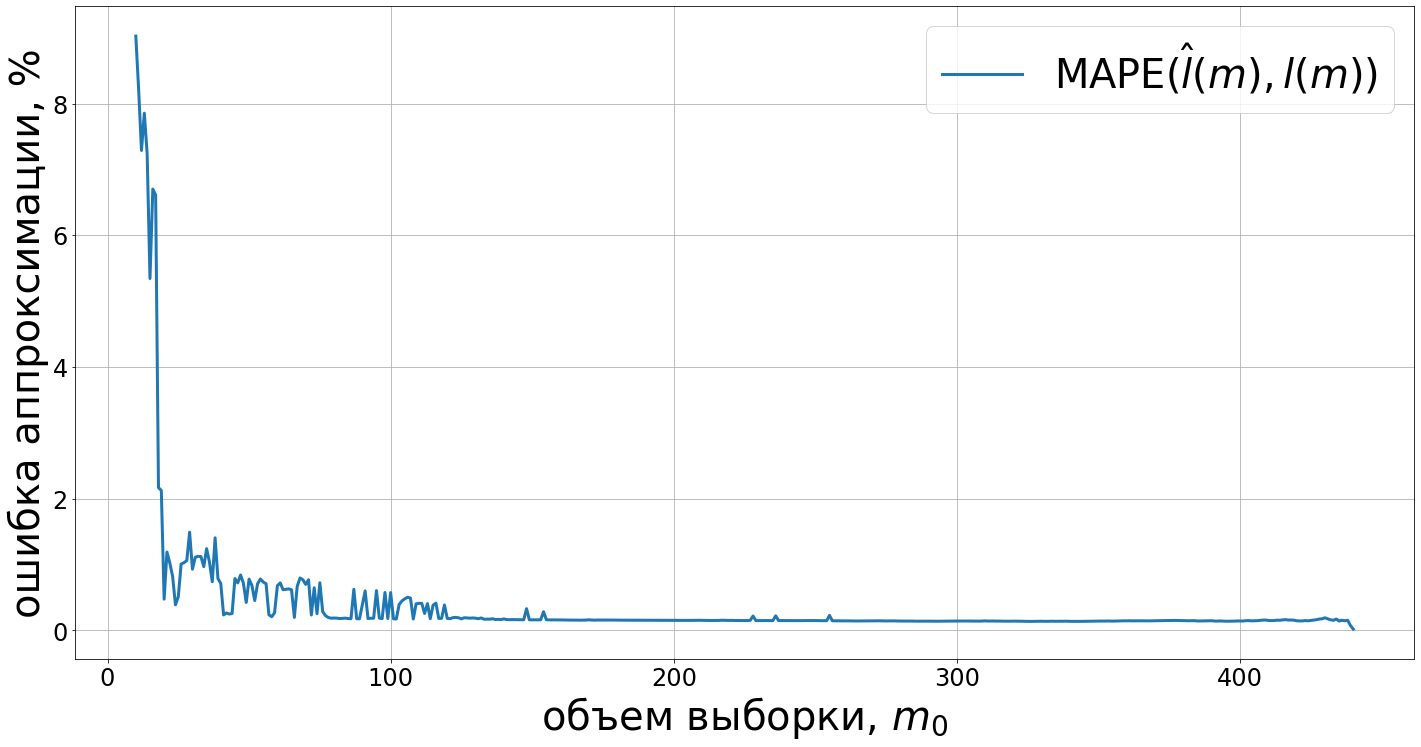

In [31]:
plt.plot(np.arange(10, M), np.array(MAPE_cheat) * 100, label='MAPE($\hat l(m), l(m)$)')

plt.xlabel('объем выборки, $m_0$')
plt.ylabel('ошибка аппроксимации, %')
plt.legend()
plt.grid()
plt.savefig('../data/pics/diabetes_l_MAPE_cheat.pdf', format='pdf')
plt.show()

In [33]:
m_0 = 50
params_50 = minimize(f, [0, 1, -0.5])
MAPE_50 = np.mean(np.absolute(params_50.x[0] + params_50.x[1] * np.arange(50 + 1, M) ** params_50.x[2] - l[50 - 9:]))
m_0 = 100
params_100 = minimize(f, [0, 1, -0.5])
MAPE_100 = np.mean(np.absolute(params_100.x[0] + params_100.x[1] * np.arange(100 + 1, M) ** params_100.x[2] - l[100 - 9:]))
m_0 = 150
params_150 = minimize(f, [0, 1, -0.5])
MAPE_150 = np.mean(np.absolute(params_150.x[0] + params_150.x[1] * np.arange(150 + 1, M) ** params_150.x[2] - l[150 - 9:]))
m_0 = 200
params_200 = minimize(f, [0, 1, -0.5])
MAPE_200 = np.mean(np.absolute(params_200.x[0] + params_200.x[1] * np.arange(200 + 1, M) ** params_200.x[2] - l[200 - 9:]))

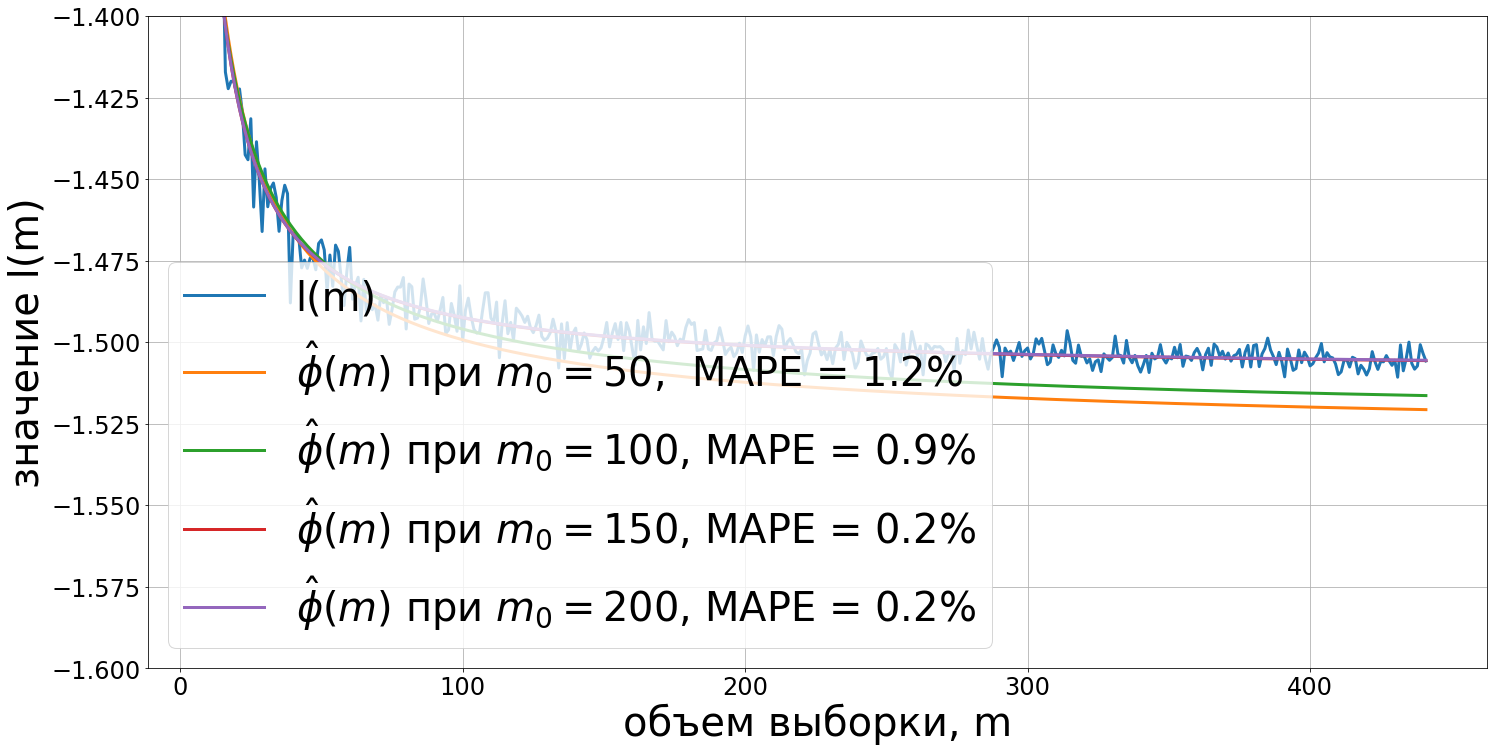

In [34]:
plt.plot(np.arange(10, M), l, label='l(m)')
plt.plot(np.arange(10, M), params_50.x[0] + params_50.x[1] * np.arange(10, M) ** params_50.x[2], label='$\hat \phi(m)$ при $m_0 = 50$,\tMAPE = {}%'.format(round(MAPE_50 * 100, 1)))
plt.plot(np.arange(10, M), params_100.x[0] + params_100.x[1] * np.arange(10, M) ** params_100.x[2], label='$\hat \phi(m)$ при $m_0 = 100$,\tMAPE = {}%'.format(round(MAPE_100 * 100, 1)))
plt.plot(np.arange(10, M), params_150.x[0] + params_150.x[1] * np.arange(10, M) ** params_150.x[2], label='$\hat \phi(m)$ при $m_0 = 150$,\tMAPE = {}%'.format(round(MAPE_150 * 100, 1)))
plt.plot(np.arange(10, M), params_200.x[0] + params_200.x[1] * np.arange(10, M) ** params_200.x[2], label='$\hat \phi(m)$ при $m_0 = 200$,\tMAPE = {}%'.format(round(MAPE_200 * 100, 1)))


plt.xlabel('объем выборки, m')
plt.ylabel('значение l(m)')
plt.ylim((-1.6, -1.4))
plt.legend()
plt.grid()
plt.savefig('../data/pics/diabetes_l_MAPE_cheat_examples.pdf', format='pdf')
plt.show()

---
Практический (честный способ) нахождения $l(m)$.

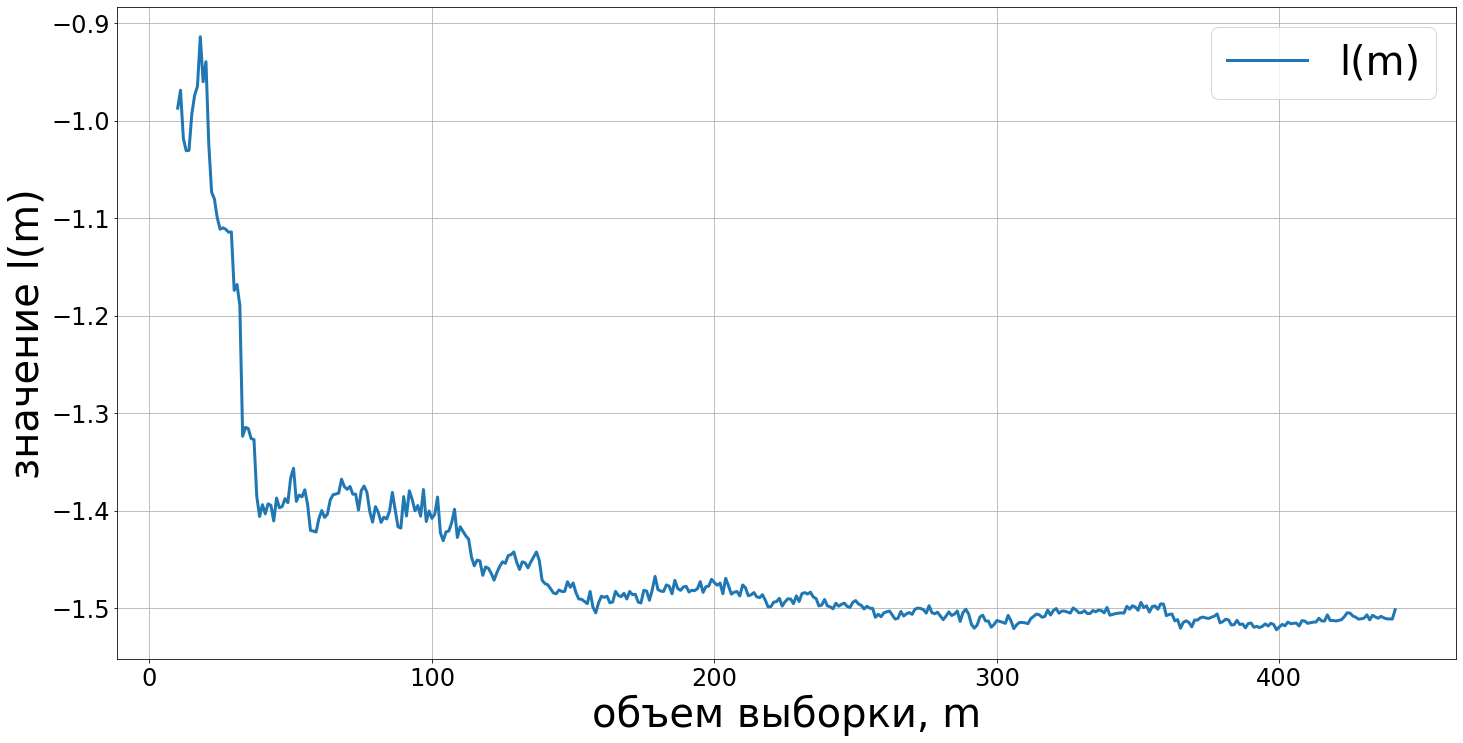

In [35]:
l_honest = []

for m in tqdm(range(10, M)):
    
    l_m = []
    
    for i in range(bootstrap_num_iter):
        idx = np.random.choice(m, size=m)
        
        X_m = X[idx]
        y_m = y[idx]
        w_hat = ut.get_params(X_m, y_m)
        cur_loc = X_m @ w_hat
        cur_std = np.std(y_m)
        l_m.append(np.mean(sps.norm(loc=cur_loc, scale=cur_std).logpdf(y_m)))
    
    l_honest.append(np.mean(l_m))
    
plt.plot(np.arange(10, M), l_honest, label='l(m)')

plt.xlabel('объем выборки, m')
plt.ylabel('значение l(m)')
plt.legend()
plt.grid()
plt.savefig('../data/pics/diabetes_l_m_0.pdf', format='pdf')
plt.show()

In [20]:
m_0 = 100

In [36]:
def f(x):
    a = x[0]
    b = x[1]
    c = x[2]
    return np.mean(np.absolute(a + b * np.arange(10, m_0 + 1) ** c - l_honest[:m_0 - 9]) / np.absolute(l_honest[:m_0 - 9]))

In [22]:
from scipy.optimize import minimize

MAPE_honest = []

for i in tqdm(range(10, M)):
    m_0 = i
    params = minimize(f, [0, 1, -0.5])
    MAPE_honest.append(np.mean(np.absolute(params.x[0] + params.x[1] * np.arange(m_0 + 1, M) ** params.x[2] - l[m_0 - 9:]) / np.absolute(l[m_0 - 9:])))

/home/coder/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/coder/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


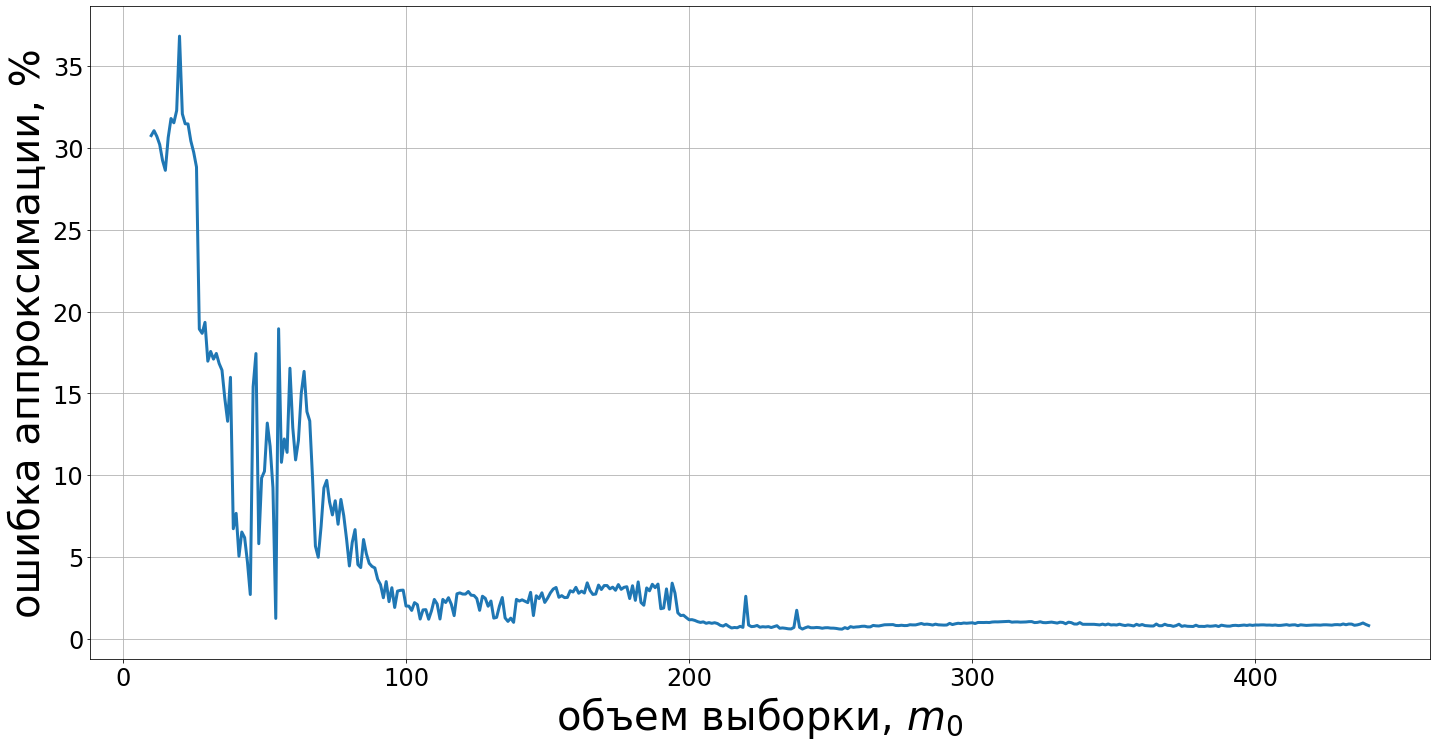

In [37]:
plt.plot(np.arange(10, M), np.array(MAPE_honest) * 100, label='MAPE($\hat l(m), l(m)$)')

plt.xlabel('объем выборки, $m_0$')
plt.ylabel('ошибка аппроксимации, %')
plt.grid()
plt.savefig('../data/pics/diabetes_l_MAPE_honest.pdf', format='pdf')
plt.show()

In [38]:
m_0 = 50
params_50 = minimize(f, [0, 1, -0.5])
MAPE_50 = np.mean(np.absolute(params_50.x[0] + params_50.x[1] * np.arange(50 + 1, M) ** params_50.x[2] - l[50 - 9:]) / np.absolute(l[50 - 9:]))
m_0 = 100
params_100 = minimize(f, [0, 1, -0.5])
MAPE_100 = np.mean(np.absolute(params_100.x[0] + params_100.x[1] * np.arange(100 + 1, M) ** params_100.x[2] - l[100 - 9:]) / np.absolute(l[100 - 9:]))
m_0 = 150
params_150 = minimize(f, [0, 1, -0.5])
MAPE_150 = np.mean(np.absolute(params_150.x[0] + params_150.x[1] * np.arange(150 + 1, M) ** params_150.x[2] - l[150 - 9:]) / np.absolute(l[150 - 9:]))
m_0 = 200
params_200 = minimize(f, [0, 1, -0.5])
MAPE_200 = np.mean(np.absolute(params_200.x[0] + params_200.x[1] * np.arange(200 + 1, M) ** params_200.x[2] - l[200 - 9:]) / np.absolute(l[200 - 9:]))
# m_0 = 500
# params_500 = minimize(f, [0, 1, -0.5])
# MAPE_500 = np.mean(np.absolute(params_500.x[0] + params_500.x[1] * np.arange(500 + 1, M) ** params_500.x[2] - l[500 - 9:]) / np.absolute(l[500 - 9:]))

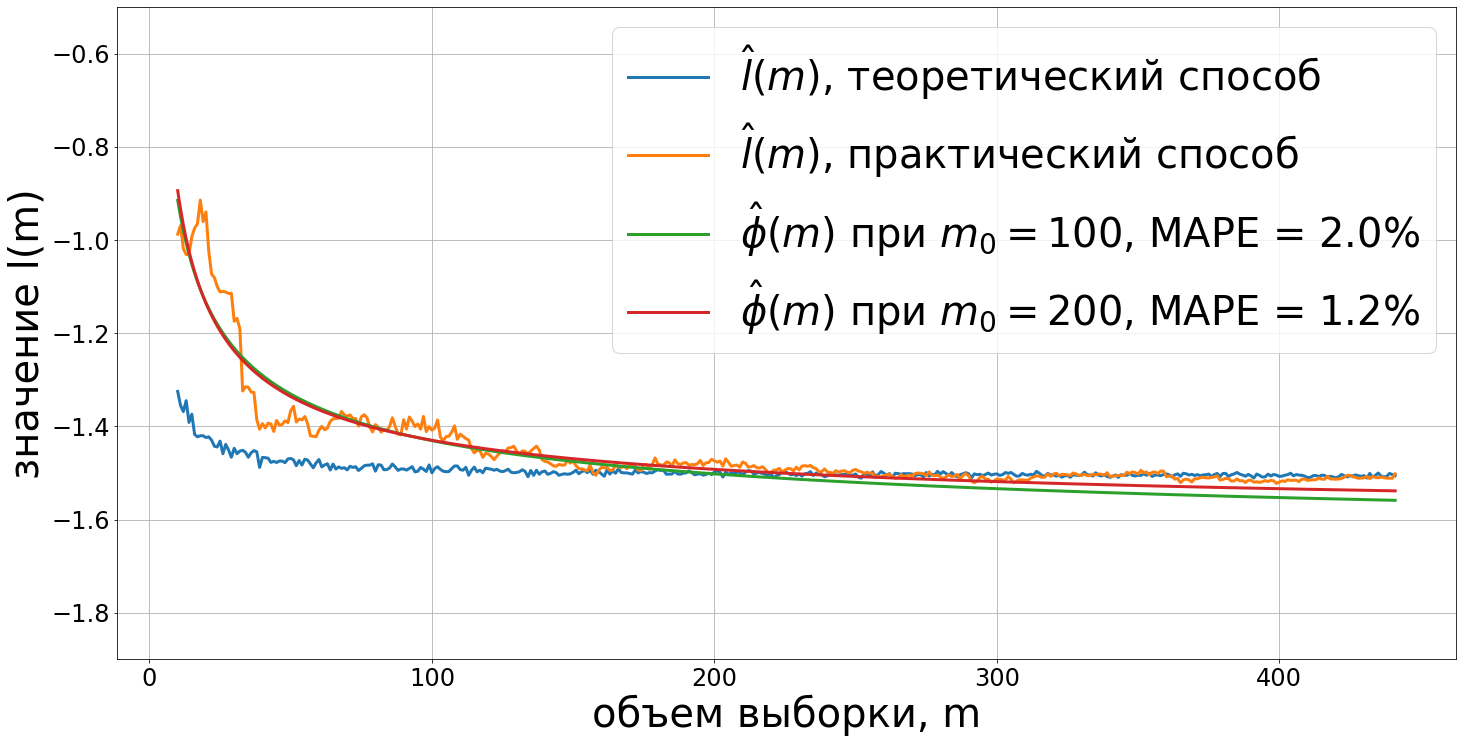

In [39]:
plt.plot(np.arange(10, M), l, label='$\hat{l}(m)$, теоретический способ')
plt.plot(np.arange(10, M), l_honest, label='$\hat{l}(m)$, практический способ')
# plt.plot(np.arange(10, M), params_50.x[0] + params_50.x[1] * np.arange(10, M) ** params_50.x[2], label='$\hat l(m)$ при $m_0 = 50$, MAPE = {}%'.format(round(MAPE_50 * 100, 1)))
plt.plot(np.arange(10, M), params_100.x[0] + params_100.x[1] * np.arange(10, M) ** params_100.x[2], label='$\hat \phi(m)$ при $m_0 = 100$, MAPE = {}%'.format(round(MAPE_100 * 100, 1)))
# plt.plot(np.arange(10, M), params_150.x[0] + params_150.x[1] * np.arange(10, M) ** params_150.x[2], label='$\hat l(m)$ при $m_0 = 150$, MAPE = {}%'.format(round(MAPE_150 * 100, 1)))
plt.plot(np.arange(10, M), params_200.x[0] + params_200.x[1] * np.arange(10, M) ** params_200.x[2], label='$\hat \phi(m)$ при $m_0 = 200$, MAPE = {}%'.format(round(MAPE_200 * 100, 1)))
# plt.plot(np.arange(10, M), params_500.x[0] + params_500.x[1] * np.arange(10, M) ** params_500.x[2], label='$\hat \phi(m)$ при $m_0 = 500$, MAPE = {}%'.format(round(MAPE_500 * 100, 1)))


plt.xlabel('объем выборки, m')
plt.ylabel('значение l(m)')
plt.ylim((-1.9, -0.5))
plt.legend(loc='upper right')
plt.grid()
plt.savefig('../data/pics/diabetes_l_MAPE_honest_examples.pdf', format='pdf')
plt.show()

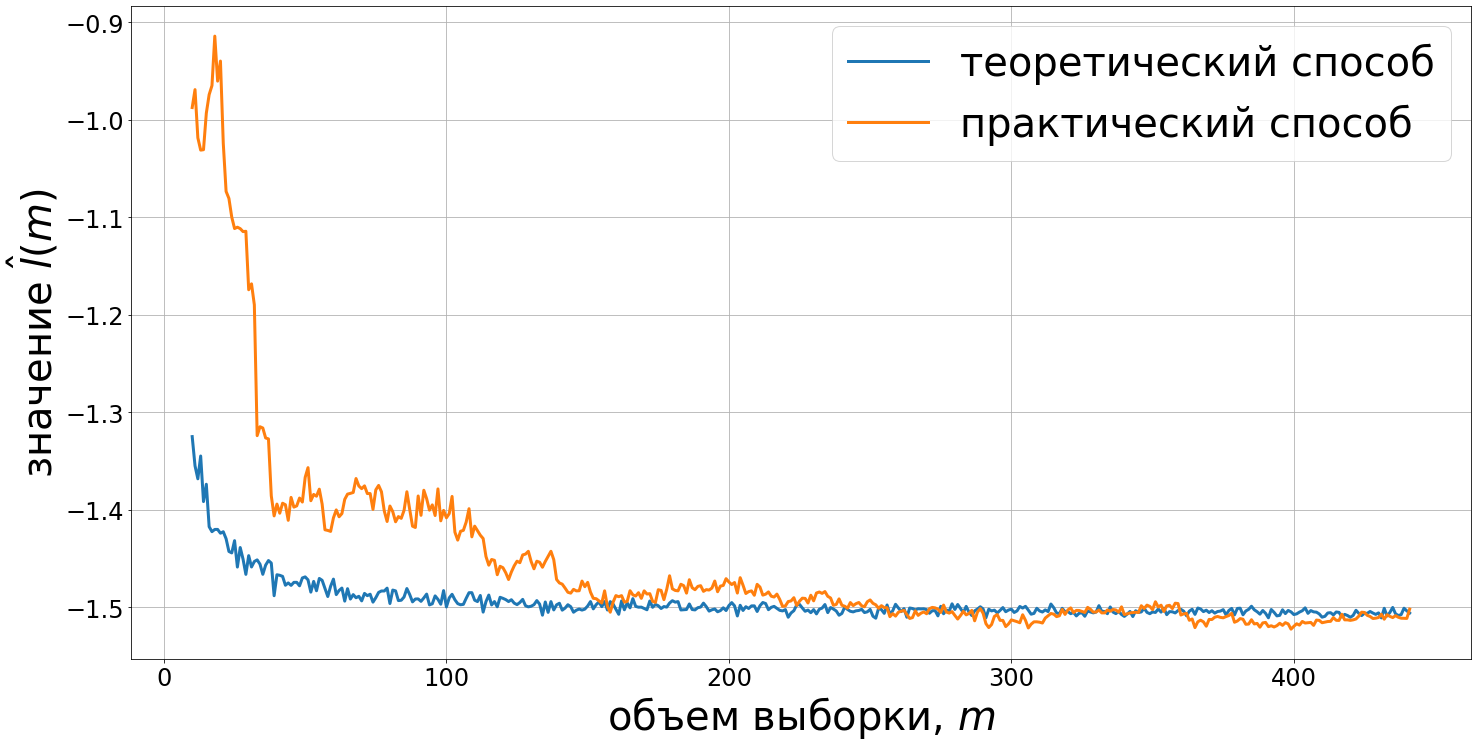

In [40]:
plt.plot(np.arange(10, M), l, label='теоретический способ')
plt.plot(np.arange(10, M), l_honest, label='практический способ')

plt.xlabel('объем выборки, $m$')
plt.ylabel('значение $\hat{l}(m)$')
plt.legend()
plt.grid()
plt.savefig('../data/pics/diabetes_l_comparison.pdf', format='pdf')
plt.show()

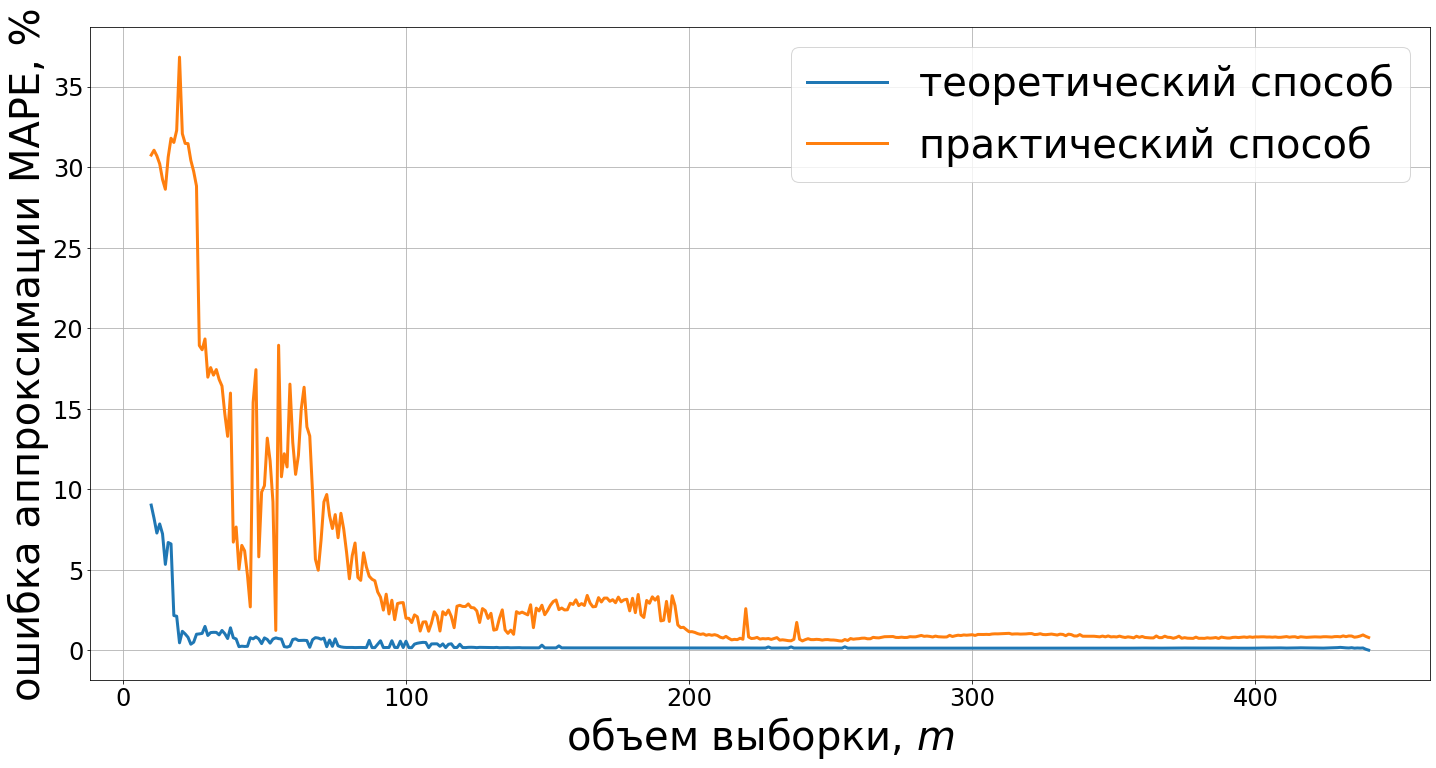

In [41]:
plt.plot(np.arange(10, M), np.array(MAPE_cheat) * 100, label='теоретический способ')
plt.plot(np.arange(10, M), np.array(MAPE_honest) * 100, label='практический способ')

plt.xlabel('объем выборки, $m$')
plt.ylabel('ошибка аппроксимации MAPE, %')
plt.legend()
plt.grid()
plt.savefig('../data/pics/diabetes_l_MAPE_comparison.pdf', format='pdf')
plt.show()

---
---
---

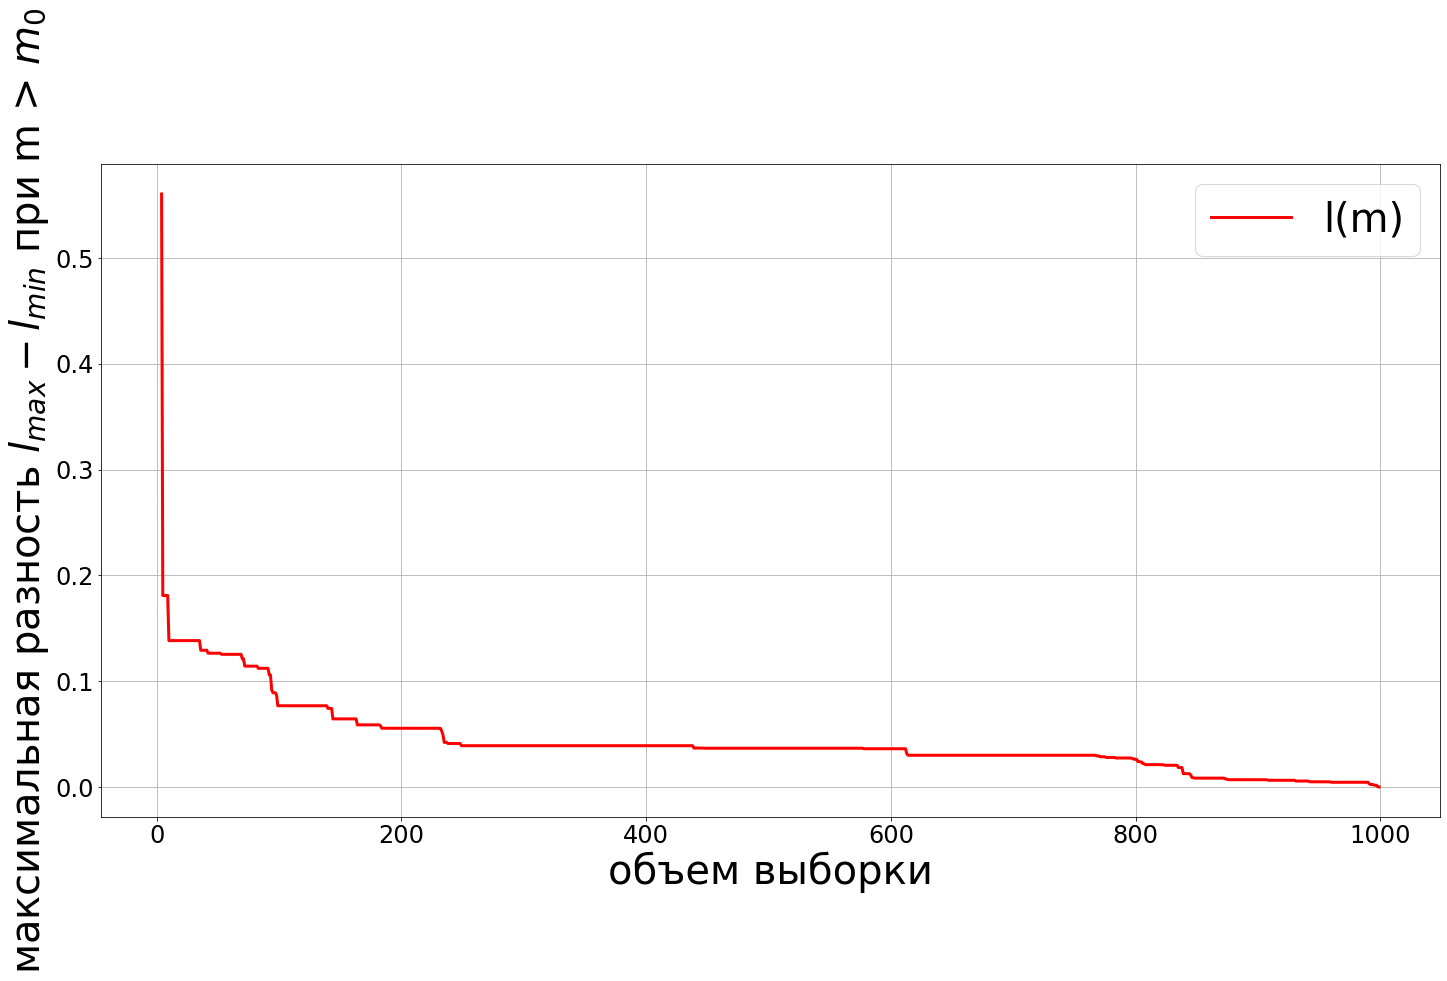

In [8]:
l_diff = []
for i in range(0, len(l)):
    l_diff.append(np.max(l[i:]) - np.min(l[i:]))
    
plt.plot(np.arange(4, X.shape[0]), l_diff, color='red', label='l(m)')

plt.xlabel('объем выборки')
plt.ylabel('максимальная разность $l_{max} - l_{min}$ при m > $m_0$')
plt.legend()
plt.grid()
#plt.savefig('../data/pics/ALC_modified_{}.pdf'.format(name), format='pdf')
plt.show()

In [54]:
# m_opt = []
eps = 0.1

m_0_max = 100

for m_0 in tqdm(range(4 + len(m_opt), m_0_max + 1)):
    X_m_0, y_m_0 = X[:m_0], y[:m_0]
    w_hat = ut.get_params(X_m_0, y_m_0)

    num_iters = 1000

    answers = []

    for i in range(num_iters):
        X_sub, y_sub = ut.get_subset(X_m_0, y_m_0, m_0 // 2, duplications=False)
        model = statmodel(y_sub, X_sub)
        w_hat = ut.get_params(X_sub, y_sub)
        answers.append((-model.hessian_fixed(w_hat) / X_sub.shape[0]))

    answers = np.asarray(answers)

    i_matrix = np.linalg.inv(np.mean(answers, axis=0))

    approx_l = []
    approx_l_std = []

    for m in tqdm(range(m_0 + 1, X.shape[0])):

        cur_l = []

        for i in range(50):
            w_hat_cur = sps.multivariate_normal(mean=w_hat, cov=i_matrix / m).rvs(size=1)
            cur_l.append(np.mean([sps.norm(loc=X @ w_hat_cur, scale=1).logpdf(y) for X, y in zip(X_m_0, y_m_0)]))

        approx_l.append(np.mean(cur_l))
        approx_l_std.append(np.std(cur_l))
    
    left_border = sps.norm(loc=0, scale=approx_l_std).ppf(0.05)
    right_border = sps.norm(loc=0, scale=approx_l_std).ppf(0.95)
        
    m_opt.append(m_0 + 1 + np.argmax((right_border - left_border < eps)))

KeyboardInterrupt: 

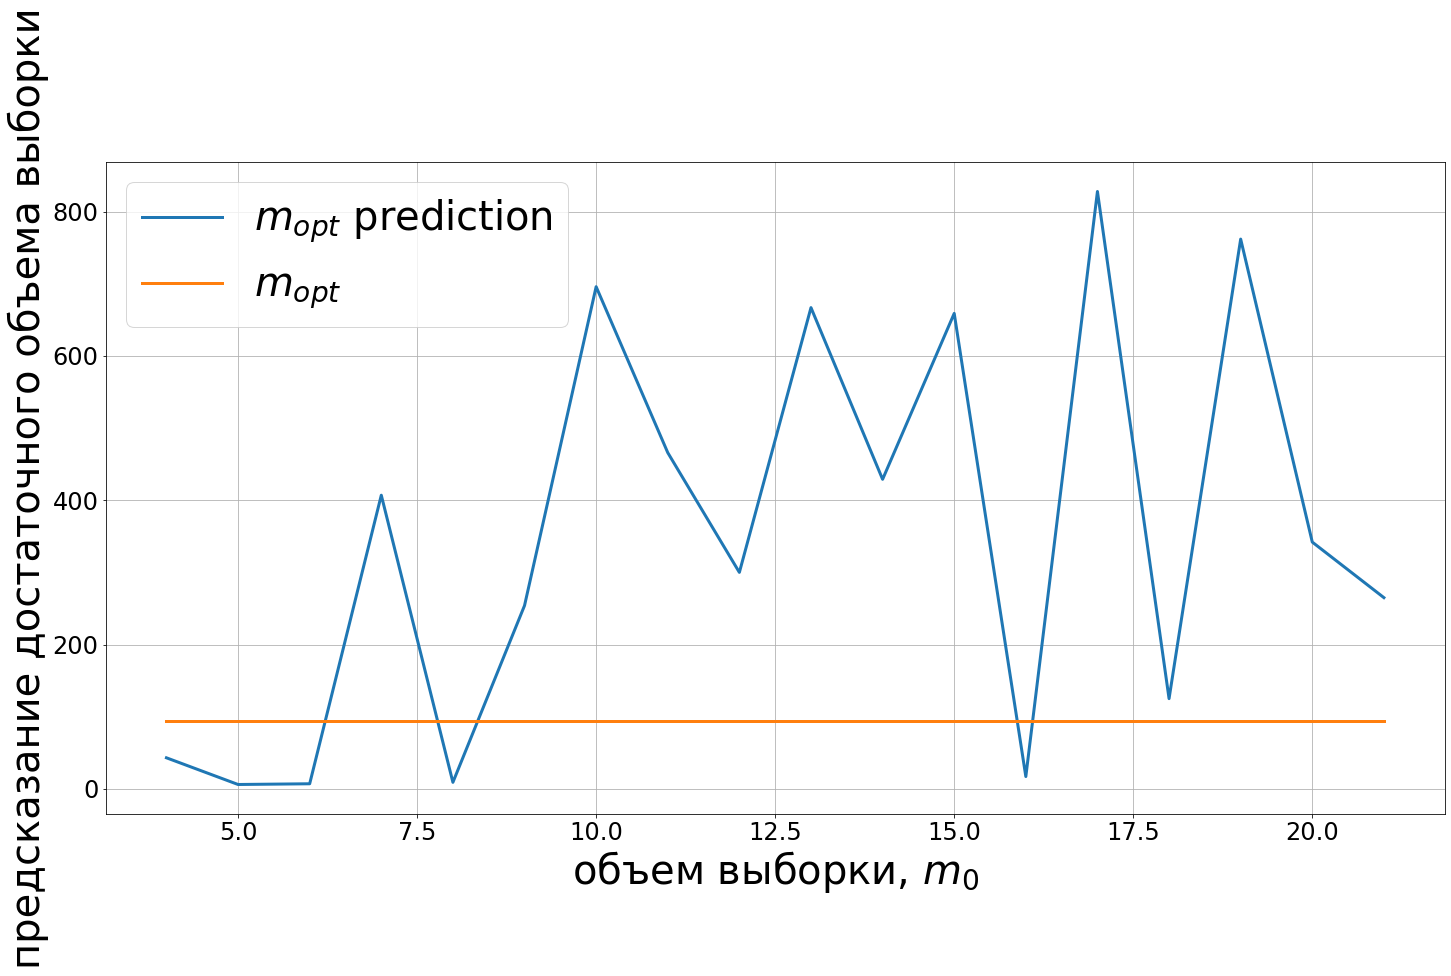

In [53]:
plt.plot(np.arange(4, 4 + len(m_opt)), m_opt, label='$m_{opt}$ prediction')
plt.plot(np.arange(4, 4 + len(m_opt)), np.zeros(len(m_opt)) + 4 + np.argmax(np.array(l_diff) < eps), label='$m_{opt}$')

plt.xlabel('объем выборки, $m_0$')
plt.ylabel('предсказание достаточного объема выборки')
plt.legend()
plt.grid()
plt.savefig('../data/pics/synthetic_approximation_m_opt_interval.pdf', format='pdf')
plt.show()

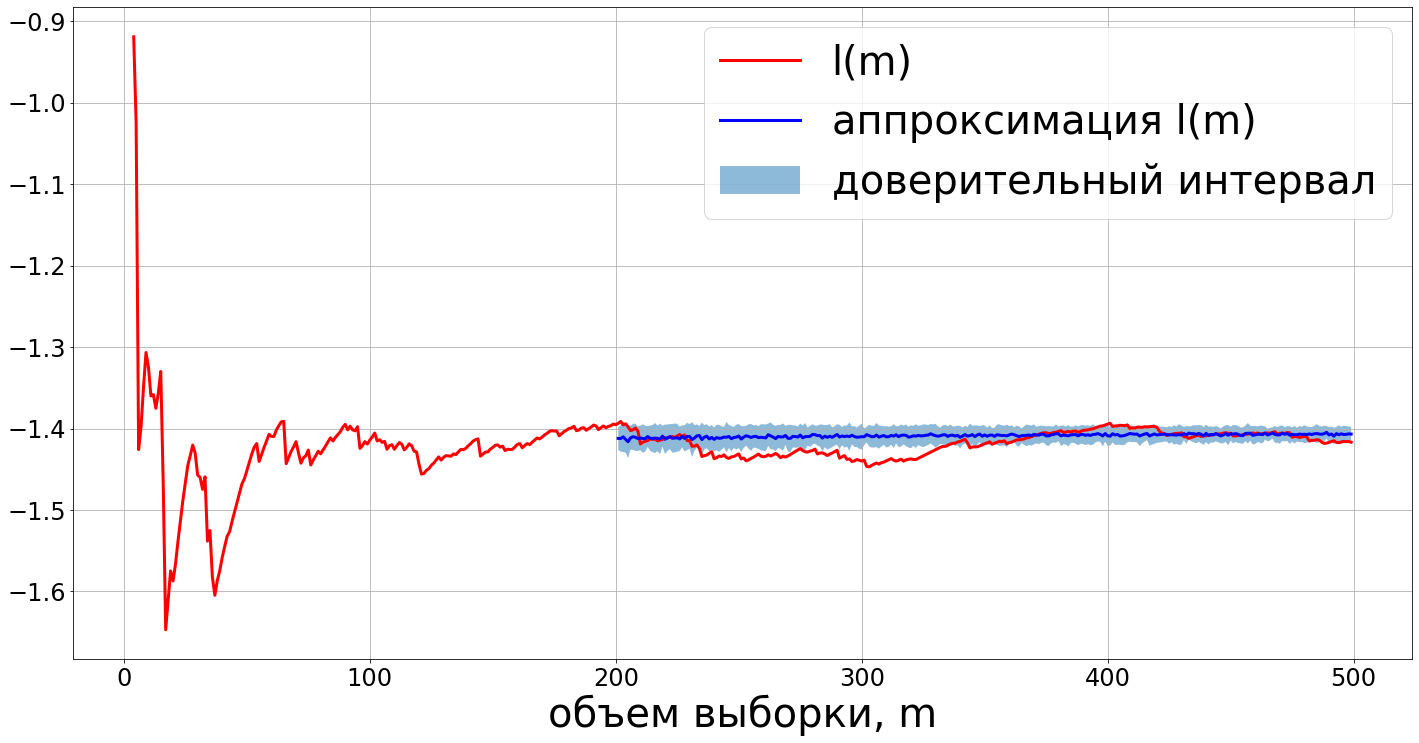

In [64]:
# m_0 = 200

# X_m_0, y_m_0 = X[:m_0], y[:m_0]
# w_hat = ut.get_params(X_m_0, y_m_0)

# num_iters = 1000

# answers = []

# for i in range(num_iters):
#     X_sub, y_sub = ut.get_subset(X_m_0, y_m_0, m_0 // 2, duplications=False)
#     model = statmodel(y_sub, X_sub)
#     w_hat = ut.get_params(X_sub, y_sub)
#     answers.append((-model.hessian_fixed(w_hat) / X_sub.shape[0]))

# answers = np.asarray(answers)

# i_matrix = np.linalg.inv(np.mean(answers, axis=0))

# approx_l = []
# approx_l_std = []

# for m in tqdm(range(m_0 + 1, 500)):

#     cur_l = []

#     for i in range(50):
#         w_hat_cur = sps.multivariate_normal(mean=w_hat, cov=np.linalg.inv(i_matrix) / m).rvs(size=1)
#         cur_l.append(np.mean([sps.norm(loc=X @ w_hat_cur, scale=1).logpdf(y) for X, y in zip(X_m_0, y_m_0)]))

#     approx_l.append(np.mean(cur_l))
#     approx_l_std.append(np.std(cur_l))
    
plt.plot(np.arange(4, 500), l[:496], color='red', label='l(m)')
plt.plot(np.arange(m_0 + 1, 500), approx_l, color='blue', label='аппроксимация l(m)')
plt.fill_between(np.arange(m_0 + 1, 500), sps.norm(loc=approx_l, scale=approx_l_std).ppf(0.05), 
                 sps.norm(loc=approx_l, scale=approx_l_std).ppf(0.95),
                 alpha=0.5, label='доверительный интервал')

plt.xlabel('объем выборки, m')
plt.legend()
plt.grid() 
plt.savefig('../data/pics/synthetic_approximation_l.pdf', format='pdf')
plt.show()